# Vorhersage eines Triebwerksausfalls aufgrund von Sensormesswerten

In [1]:
import h5py
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [ ]:
filename = '../data/N-CMAPSS_DS03-012.h5'

In [3]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # Sensors
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # Sensors
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))

In [7]:
df_A = DataFrame(data=A_dev, columns=A_var)
df_A_test = DataFrame(data=A_test, columns=A_var)
df_A.describe()


,unit,cycle,Fc,hs
count,5.571277e+06,5.571277e+06,5.571277e+06,5.571277e+06
mean,5.382994e+00,3.637726e+01,2.170105e+00,3.319295e-01
std,2.399958e+00,2.157529e+01,7.257075e-01,4.709059e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,1.800000e+01,2.000000e+00,0.000000e+00
50%,6.000000e+00,3.600000e+01,2.000000e+00,0.000000e+00
75%,8.000000e+00,5.400000e+01,3.000000e+00,1.000000e+00
max,9.000000e+00,9.300000e+01,3.000000e+00,1.000000e+00


### Unit Ids 
Mit diesem Codeabschnitt wird geschaut wie viele Triebwerke im Devset und im Testset sind.

In [8]:
print(np.unique(df_A["unit"]))
print(np.unique(df_A_test["unit"]))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[10. 11. 12. 13. 14. 15.]


### Verfügbare Triebwerke pro Flugklasse

Text(0, 0.5, 'Flight Class # [-]')

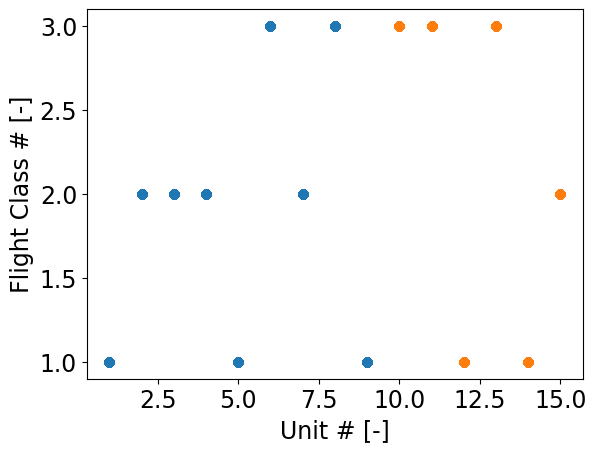

In [9]:
labelsize = 17
# devset 
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

# testset
plt.plot(df_A_test.unit, df_A_test.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

## Analyse der Sensordaten

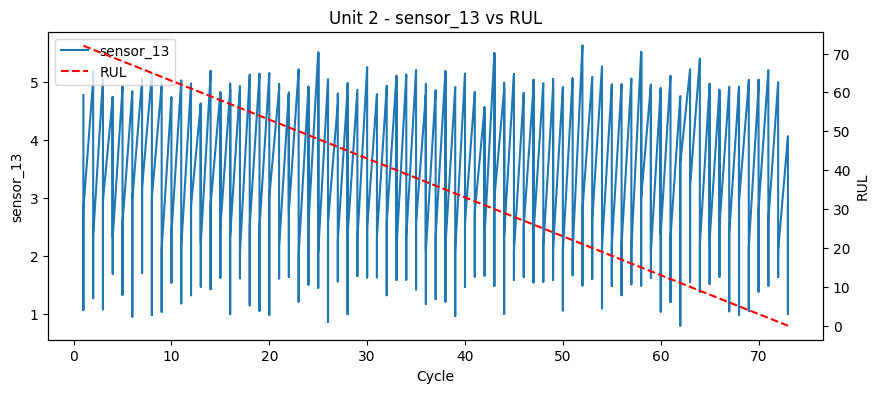

In [10]:
df = DataFrame(X_s_dev, columns=[f"sensor_{i}" for i in range(X_s_dev.shape[1])])

# Add auxiliary info
df["unit"]  = A_dev[:, 0].astype(int)
df["cycle"] = A_dev[:, 1].astype(int)
df["Fc"]    = A_dev[:, 2].astype(int)
df["hs"]    = A_dev[:, 3].astype(int)

# Add target (RUL)
df["RUL"] = Y_dev

unit_to_plot = 2          # pick a unit
sensor = "sensor_13"       # pick a sensor column name

df_unit = df[df["unit"] == unit_to_plot]

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(df_unit["cycle"], df_unit[sensor], label=sensor)
ax1.set_xlabel("Cycle")
ax1.set_ylabel(sensor)

ax2 = ax1.twinx()
ax2.plot(df_unit["cycle"], df_unit["RUL"], linestyle="--", color="red", label="RUL")
ax2.set_ylabel("RUL")

# Merge legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title(f"Unit {unit_to_plot} - {sensor} vs RUL")
plt.show()


Text(0.5, 1.0, 'Unit 2 - Cycle 5 - sensor_5')

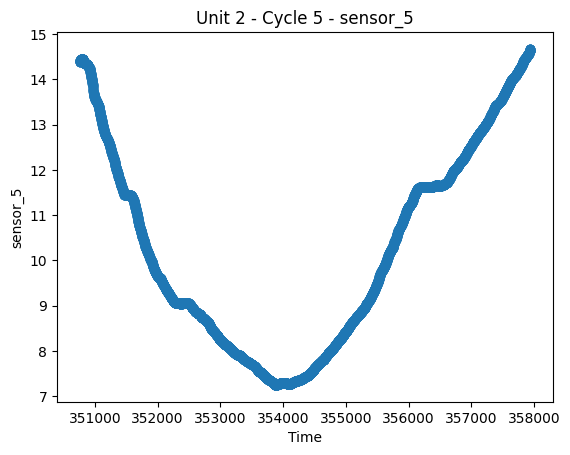

In [11]:
unit_to_plot = 2          # pick a unit
cycle_to_plot = 5      # pick a cycle 
sensor = "sensor_5"       # pick a sensor column name

df = DataFrame(X_s_dev, columns=[f"sensor_{i}" for i in range(X_s_dev.shape[1])])
df["unit"]  = A_dev[:, 0].astype(int)
df["cycle"] = A_dev[:, 1].astype(int)
df["tra"] = W_dev[:, 2].astype(float)

df_unit_cycle = df[(df["unit"] == unit_to_plot) & (df["cycle"] == cycle_to_plot)]
df_unit_cycle.describe()

plt.plot(df_unit_cycle[sensor], 'o')
plt.xlabel("Time")
plt.ylabel(sensor)
plt.title(f"Unit {unit_to_plot} - Cycle {cycle_to_plot} - {sensor}")

c:\Users\leonk\Documents\KSWO\MAR\Turbofan_NASA_Data\17. Turbofan Engine Degradation Simulation Data Set 2\data_set\data_set\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


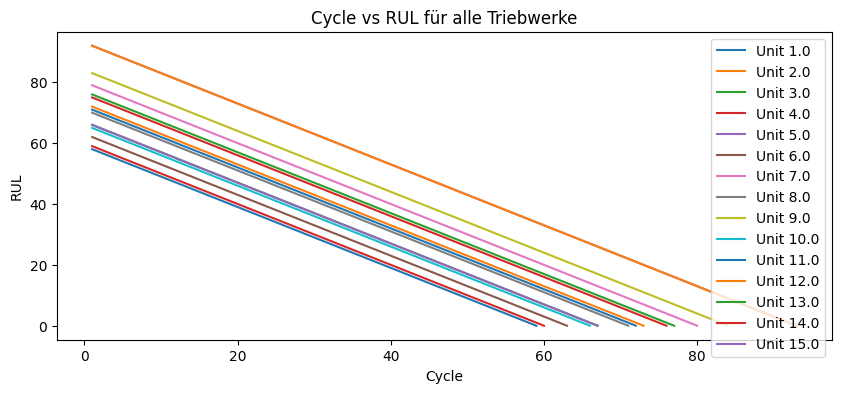

In [18]:
A = np.concatenate((A_dev, A_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0)
df = DataFrame(A, columns=A_var)
df["rul"] = Y

unique_units = df["unit"].unique()

plt.figure(figsize=(10, 4))
for unit in unique_units:
    df_unit = df[df["unit"] == unit]
    plt.plot(df_unit["cycle"], df_unit["rul"], label=f"Unit {unit}")
    
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("Cycle vs RUL für alle Triebwerke")
plt.legend()
plt.show()

## Datenaufbereitung

In [4]:
# Train
cycle = A_dev[:, 1].reshape(-1, 1)
fc = A_dev[:, 0].reshape(-1, 1)
X_dev = X_s_dev[:,[2]] 
X_train = np.concatenate((X_dev, cycle, fc, W_dev), axis=1)
Y_train = Y_dev.ravel()

# Test
cycle_test = A_test[:, 1].reshape(-1, 1)
fc_test = A_test[:, 0].reshape(-1, 1)
X_test = X_s_test[:, [2]]
X_test = np.concatenate((X_test, cycle_test, fc_test, W_test), axis=1)
Y_test = Y_test.ravel()

## Random Forest

In [5]:
# Import
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import joblib

### Model Training

In [ ]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# Save the model
joblib.dump(model, '..models/rul_random_forest_cycle.pkl')


### Vorhersage

In [ ]:
# Load the model
model = joblib.load('../models/rul_random_forest.pkl')
print("Model loaded")

# Predict
Y_pred = model.predict(X_test)

Model loaded


### Evaluation

In [11]:
# Evaluation
rmse = root_mean_squared_error(Y_test, Y_pred)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 16.15


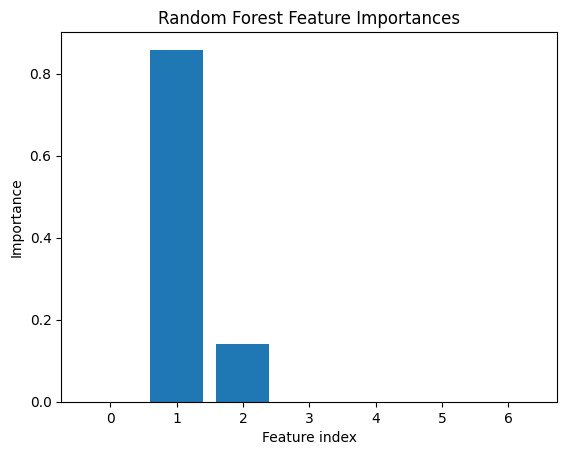

In [12]:
# Feature importances
importances = model.feature_importances_
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()

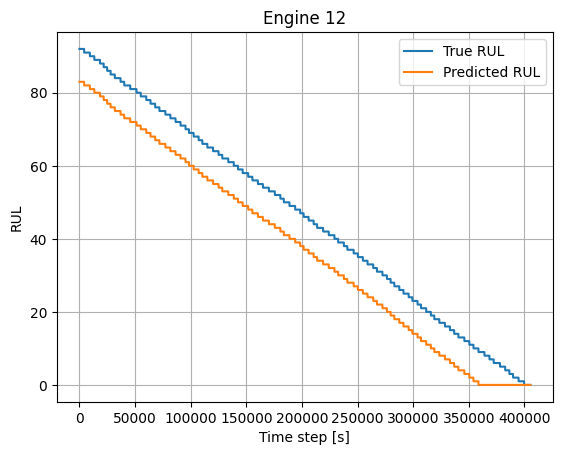

In [14]:
unit_ids_test = A_test[:, 0]
unit = 12
indices = np.where(unit_ids_test == unit)[0]

plt.plot(Y_test[indices], label="True RUL")
plt.plot(Y_pred[indices], label="Predicted RUL")
plt.title(f"Engine {unit}")
plt.xlabel("Time step [s]")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()
